In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nbimporter 
from Functions_New import RMA_newton, B20_control, generator_B20
from Functions import time_stamp, plt_visu, plot_multiple, residual_analysis

Importing Jupyter notebook from Functions.ipynb


### I. Explorative Data Analysis

##### A) Breaking down the B20 Linear Strain

In [2]:
n = 100  # number of observations / strain
N = 400  # number of strains generated to train
E = 200000 ; b = 0.001 ; A = 1000 ; a = 0.2 # parameters for the steel

In [3]:
strain_=[]
stress_=[]
for stop in np.arange(10,100,10):
    new_=B20_control(n,stopping=stop,peak=0.10)[1]
    strain_.append(new_)
    rma=RMA_newton(new_)
    rma.activate(E,A,b,a)
    stress_.append(rma.stress)

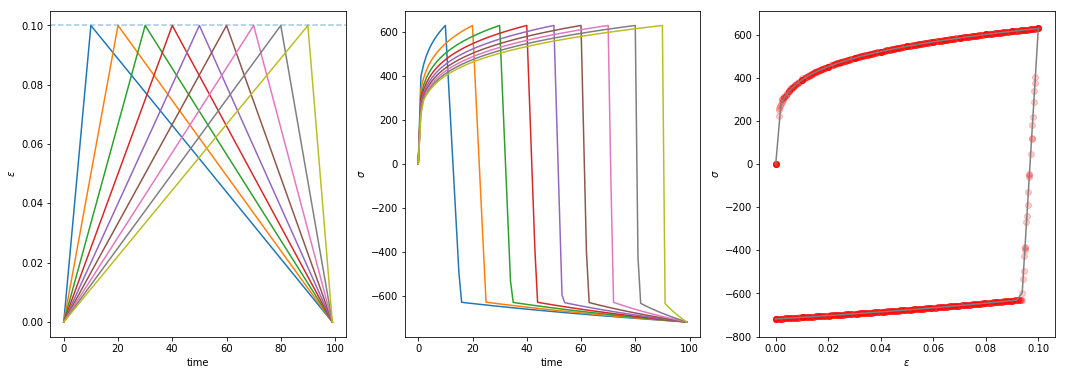

In [4]:
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,3,1)
for el in strain_:
    plt.plot(el)
plt.xlabel('time')
plt.ylabel('$\epsilon$')
plt.axhline(0.10,alpha=0.4,ls='--')

plt.subplot(1,3,2)
for el in stress_:
    plt.plot(el)
plt.xlabel('time')
plt.ylabel('$\sigma$')

plt.subplot(1,3,3)
plt.plot(strain_[4],stress_[4],color='grey')
for el1,el2 in zip(strain_,stress_):
    plt.scatter(el1,el2,color='red',alpha=0.2)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')
plt.show()

I have been wasting so much time creating strain that had less values on one side of peak and more on the other. This does not matter ! Time here does not exist ! We are just interpolating values between the peak !!! **This is PROBABLY why the Neural Network did not work perfectly.** The only thing that matters is the value of the peak. Then we just assume we interpolate as many values on each side ! Let us train a Deep Feedforward Neural Network with 50 values on each side of the peak.

##### B) Visualizing the Idea of the Dataset

In [5]:
strain_2=[]
stress_2=[]
for pk in np.linspace(0.001,0.2,10):
    new_=B20_control(n,stopping=50,peak=pk)[1]
    strain_2.append(new_)
    rma=RMA_newton(new_)
    rma.activate(E,A,b,a)
    stress_2.append(rma.stress)

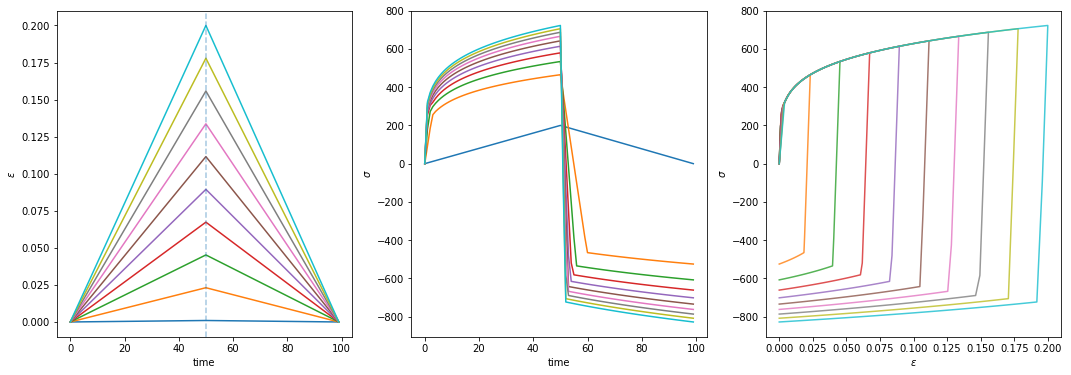

In [6]:
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,3,1)
for el in strain_2:
    plt.plot(el)
plt.xlabel('time')
plt.ylabel('$\epsilon$')
plt.axvline(50,alpha=0.4,ls='--')

plt.subplot(1,3,2)
for el in stress_2:
    plt.plot(el)
plt.xlabel('time')
plt.ylabel('$\sigma$')

plt.subplot(1,3,3)
#plt.plot(strain_[4],stress_[4],color='grey')
for el1,el2 in zip(strain_2,stress_2):
    plt.plot(el1,el2,alpha=0.8)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')
plt.show()

**Strain-Stress curve only influences by height of the peak !**

##### C) Building the dataset accordingly

In [7]:
X_train,X_test=generator_B20(100,50,4000)
y_train=[] ; y_test=[]

In [9]:
for el in X_train:
    rma=RMA_newton(el)
    rma.activate(E,A,b,a)
    y_train.append(rma.stress)

for el in X_test:
    rma=RMA_newton(el)
    rma.activate(E,A,b,a)
    y_test.append(rma.stress)

In [10]:
X_train=np.array(X_train) ; X_test=np.array(X_test) ; y_train=np.array(y_train) ; y_test=np.array(y_test)

In [12]:
np.save('X_train.npy',X_train) ; np.save('y_train.npy',y_train)
np.save('X_test.npy',X_test) ; np.save('y_test.npy',y_test)

### II. Model - Hidden Layers (139,127,113,103) - No dropout, No regularization

Best results so far:
* **Number of samples** : 4000 (training)
* **Number of samples** : 400 (test)
* **Training loss**     : 1.37
* **Test cost**         : 156.7
* **Training Time**     : 5min for 1000 epochs
* **Accuracy**          : 89%  

There is some overfitting, however results remaining pretty good. Add dropout and maybe L2 Regularization to avoid the overfitting and have a better performance

In [7]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model-1000")
    sess.run(test_init,feed_dict={batch_size:400})
    try:
        while True:
            strain_test,stress_test,stress_pred = sess.run([strain,stress,output_final])
    except tf.errors.OutOfRangeError:
        pass

INFO:tensorflow:Restoring parameters from ./tmp/model-1000


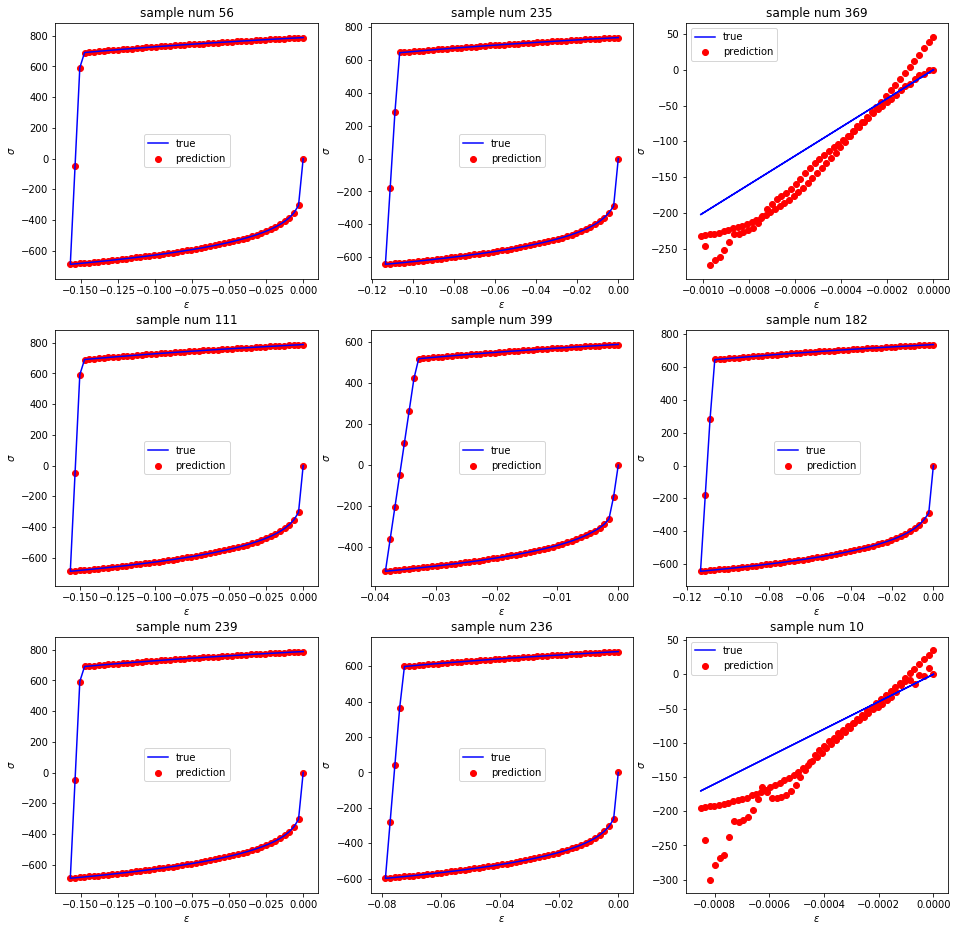

In [9]:
plot_multiple(strain_test,stress_test,stress_pred)

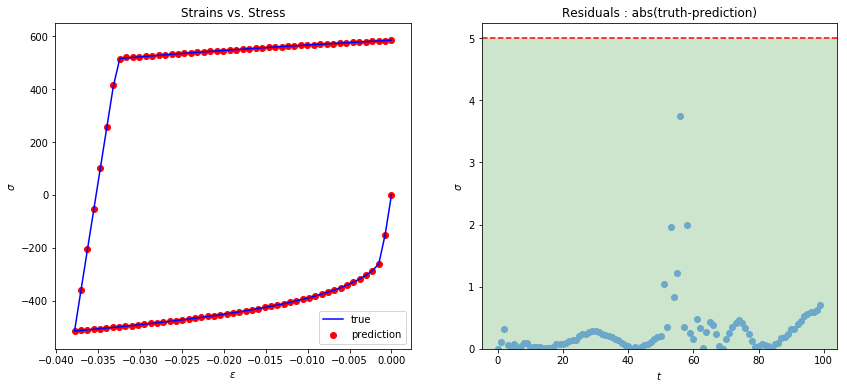

In [10]:
residual_analysis(strain_test,stress_test,stress_pred,11)

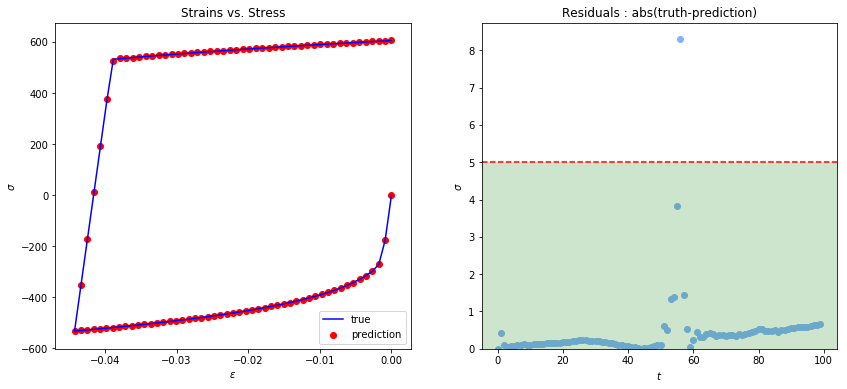

In [11]:
residual_analysis(strain_test,stress_test,stress_pred,112)

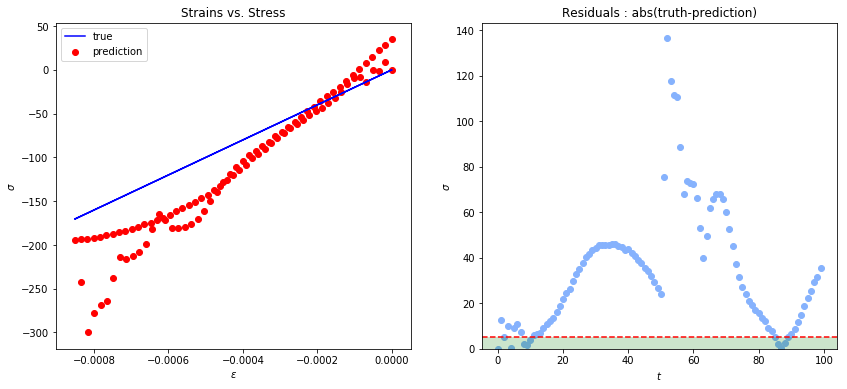

In [12]:
residual_analysis(strain_test,stress_test,stress_pred,10)

The Neural network still fails to correctly identify the stress behavior of strains which take very low values. Yet the results are very encouraging.  


**Potential Next Steps :**
* Train with more low peaked strains for B20 Linear Strains
* Observe that the only think that matters is the number of peak and the height of the peak NOT THE CURVE BETWEEN THE PEAKS ! the only important things is that between each oscillations we keep the same number of observations : Linearly spaced observations between each max_peak and min_peak !
* Add dropout and L2 Regularization. Though if the network only fails for low valued strains, retraining with a more homogenous dataset might be largely sufficient
* Reduce size of network to significantly decrease number of parameters. Though 5 min in training seems very okay !
* Maybe map strain to different neural networks given the number of oscillations/peaks
